# Evaluation of Models For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *MM/DD/20YY*
***
**Description:**
Notebook to evaluate a model on test data
***
**TODOs:**
 - <font color='red'> Generate tiled seqs 66bp windows ohe --> going to involve going back into each dataset and building .npy objects and then compiling </font>
 - <font color='red'> Perform a feature importance analysis of some kind of microscope seqs? </font>
***

# Set-up

In [1]:
# Classics
import os
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

# For stats
from scipy import stats

# Load local libraries
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
sys.path.append('/cellar/users/aklie/projects/EUGENE/eugene/utils')
sys.path.append('/cellar/users/aklie/projects/EUGENE/eugene/models')
sys.path.append('/cellar/users/aklie/projects/EUGENE/eugene/interpret/')
sys.path.append('/cellar/users/aklie/bin/make_it_train/')
import project_utils
import enhancer_utils

# Deep learning time
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

# Check for GPU
print("Using a GPU? {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print("Device number [0-7]: {}".format(torch.cuda.current_device()))
    print("Running on {} devices".format(torch.cuda.device_count()))

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

Using a GPU? True
Device number [0-7]: 0
Running on 1 devices


In [2]:
# Data params
TRAIN_DATASET = "2021_OLS_Library"
FEATURES = "ohe-seq"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.09-0.4"  # Preprocessing steps, separated by "-"
SPLIT = 0.9
SUBSET = False

In [3]:
# Architecture params
HYPERPARAM = "baseline"
ARCHITECTURE = "ssLSTM"
BATCH_SIZE=256
EPOCHS_TRAINED = 23
BIDIRECTIONAL = True
RECURRENT = True

In [4]:
# Out directory
if BIDIRECTIONAL:
    OUTDIR="../results/benchmark/{}_{}_{}_bi{}".format(PREPROCESS, FEATURES, HYPERPARAM, ARCHITECTURE)
else:
    OUTDIR="../results/benchmark/{}_{}_{}_{}".format(PREPROCESS, FEATURES, HYPERPARAM, ARCHITECTURE)
if not os.path.exists(OUTDIR):
    print("Directory doesn't exist, can't load model directory {}".format(OUTDIR))
else:
    print("Loading model from {}".format(OUTDIR))

Loading model from ../results/benchmark/0.09-0.4_ohe-seq_baseline_bissLSTM


# Load model

In [5]:
if ARCHITECTURE == "ssLSTM":
    from models import ssLSTM
    if BIDIRECTIONAL:
        print("Loading a single stranded, bidirectional LSTM model")
        eugene = ssLSTM(bidirectional=True, hidden_size=64, num_layers=3)
    else:
        print("Loading a single stranded, unidirectional LSTM model")
        eugene = ssLSTM(bidirectional=False, hidden_size=64, num_layers=3)
elif ARCHITECTURE == "dsLSTM":
    from models import dsLSTM
    if BIDIRECTIONAL:
        print("Loading a double stranded, bidirectional LSTM model")
        eugene = dsLSTM(bidirectional=True, hidden_size=64, num_layers=3)
    else:
        print("Loading a double stranded, unidirectional LSTM model")
        eugene = dsLSTM(bidirectional=False, hidden_size=64, num_layers=3)
elif ARCHITECTURE == "DeepSea":
    print("Loading a DeepSea CNN model")
    from models import DeepSea
    eugene = DeepSea(first_channels=16, second_channels=8)
else:
    print("{} is not a currently supported model architecture".format(ARCHITECTURE))
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on:", device)
print("Loading previous model at {}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE),)
eugene.load_state_dict(torch.load("{}/{}_{}_{}_{}-clf_{}.pt".format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM, EPOCHS_TRAINED, ARCHITECTURE), map_location=torch.device(device)))
eugene.to(device)
eugene.eval()

Loading a single stranded, bidirectional LSTM model
Executing the model on: cuda
Loading previous model at ../results/benchmark/0.09-0.4_ohe-seq_baseline_bissLSTM/0.09-0.4_ohe-seq_baseline_23-clf_ssLSTM.pt


ssLSTM(
  (lstm): LSTM(4, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
# Load training dataframe
OLS_dataset = pd.read_csv("../data/2021_OLS_Library/2021_OLS_Library.tsv", sep="\t")
OLS_dataset.head(1)

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NAME,SEQ,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,SEQ_LEN,linker_1,TFBS_1,linker_2,TFBS_2,linker_3,TFBS_3,linker_4,TFBS_4,linker_5,TFBS_5,linker_6
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767,66,S1,G1R,S2,E1F,S3,E2F,S4,G2R,S5,G3F,S6


# Load testing data and build dataloaders

## Validation set

In [7]:
# Load validation into a dataloader
X_val = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_val = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(TRAIN_DATASET, LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)
id_val = np.loadtxt("../data/{}/id/{}_id-test-{}.txt".format(TRAIN_DATASET, PREPROCESS, round(1-SPLIT, 1)), dtype=str)
if not RECURRENT:
    X_val = np.transpose(X_val, axes=(0, 2, 1))
    
if "ds" in ARCHITECTURE:
    print("Testing double stranded model, loading reverse seqs")
    X_val_rev = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}-rev.npy'.format(TRAIN_DATASET.replace("-", "_"), FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))  
    val_dataset = TensorDataset(torch.from_numpy(np.stack([X_val, X_val_rev], axis=3)), torch.from_numpy(y_val))   
else:
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Dimensions of validation set: 19755 x torch.Size([66, 4])


# Holdout set

In [8]:
X_holdout = np.load("../data/{}/{}/{}_X-holdout_{}.npy".format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, FEATURES))
id_holdout = np.loadtxt("../data/{}/id/{}_id-holdout.txt".format(TRAIN_DATASET, PREPROCESS), dtype=str)
if not RECURRENT:
    X_holdout = np.transpose(X_holdout, axes=(0, 2, 1))
if "ds" in ARCHITECTURE:
    print("Testing double stranded model, loading reverse seqs")
    X_holdout_rev = np.load("../data/{}/{}/{}_X-holdout_{}-rev.npy".format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, FEATURES))
    holdout_dataset = TensorDataset(torch.from_numpy(np.stack([X_holdout, X_holdout_rev], axis=3)),torch.empty(size=(len(X_holdout), 1)))   
else:
    holdout_dataset = TensorDataset(torch.from_numpy(X_holdout), torch.empty(size=(len(X_holdout), 1)))
    
holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Dimensions of heldout set: {} x {}".format(len(holdout_loader.dataset), holdout_loader.dataset[0][0].shape))

Dimensions of heldout set: 263252 x torch.Size([66, 4])


# Full genomic seqs (only applicable to an RNN)

In [9]:
# Need to save tiled ohe
X_genomic = np.load("../data/All_Genomic_Sequences/ohe_seq/X_ohe-seq.npy", allow_pickle=True)
if "ds" in ARCHITECTURE:
    print("Testing double stranded model, loading reverse seqs")
    X_genomic_rev = np.load("../data/All_Genomic_Sequences/ohe_seq/X_ohe-seq-rev.npy", allow_pickle=True)
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y-tiled_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id-tiled.txt", dtype=str)

## Get predictions

In [10]:
# Get the best model results
prob_thresh = 0.5
dataloaders = {"validation": val_loader, "holdout": holdout_loader}
y_outputs = {'validation': torch.empty(size=(len(X_val), 1)), 
             'holdout': torch.empty(size=(len(X_holdout), 1)),
             'full_genomic': torch.empty(size=(sum([len(dataset) for dataset in X_genomic]), 1))}
y_targets = {}
for phase in ['validation', 'holdout']:
    len_set = len(dataloaders[phase].dataset)
    for batch, (inputs, _) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        if "ds" in ARCHITECTURE:
            input_forward = inputs[:, :, :, 0].to(device)
            input_reverse = inputs[:, :, :, 1].to(device)
            outputs = eugene(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = eugene(inputs.float()).detach()
        if BATCH_SIZE*(batch+1) < len_set:
            y_outputs[phase][BATCH_SIZE*batch:BATCH_SIZE*(batch+1)] = outputs
        else:
            y_outputs[phase][BATCH_SIZE*batch:len_set] = outputs

In [11]:
# Have to do it this way for genomic because they are all different sizes
i = 0
for i_dataset, dataset in enumerate(X_genomic):
    for i_input, inputs in enumerate(dataset):
        inputs = torch.unsqueeze(torch.tensor(inputs), dim=0).float().to(device)
        if "ds" in ARCHITECTURE:
            input_forward = inputs
            input_reverse = torch.unsqueeze(torch.tensor(X_genomic_rev[i_dataset][i_input]), dim=0).float().to(device)
            outputs = eugene(input_forward.float(), input_reverse.float()).detach()
        else:
            inputs = inputs.to(device)
            outputs = eugene(inputs.float()).detach()
        y_outputs["full_genomic"][i] = outputs
        i+=1

In [12]:
# Compile predictions on val
y_val_outs = y_outputs["validation"]
y_val_probs = torch.sigmoid(y_val_outs).detach().numpy().squeeze()
y_val_preds = (y_val_probs >= prob_thresh).astype(int)
clf_val_df = pd.DataFrame(data={"NAME": id_val, "PREDS": y_val_preds, "SCORES": y_val_probs})
val_df = pd.merge(OLS_dataset, clf_val_df, on="NAME")

In [13]:
# Compile predictions on holdout
y_holdout_outs = y_outputs["holdout"]
y_holdout_probs = torch.sigmoid(y_holdout_outs).detach().numpy().squeeze()
y_holdout_preds = (y_holdout_probs >= prob_thresh).astype(int)
clf_holdout_df = pd.DataFrame(data={"NAME": id_holdout, "PREDS": y_holdout_preds, "SCORES": y_holdout_probs})
holdout_df = pd.merge(OLS_dataset, clf_holdout_df, on="NAME")

In [14]:
# Compile predictions on full genomic
y_full_genomic_outs = y_outputs["full_genomic"]
y_full_genomic_probs = torch.sigmoid(y_full_genomic_outs).detach().numpy().squeeze()
y_full_genomic_preds = (y_full_genomic_probs >= prob_thresh).astype(int)
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences.tsv", sep="\t")
genomic_dataset["PREDS"] = y_full_genomic_preds
genomic_dataset["SCORES"] = y_full_genomic_probs

# Evaluate on validation sequences

In [15]:
# Set data to be val
data = val_df

## <u> **Confusion matrix** </u>

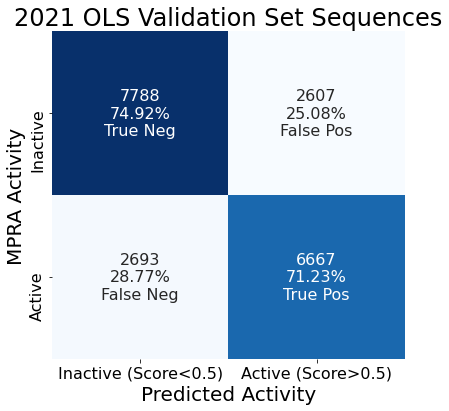

In [16]:
project_utils.cf_plot_from_df(data, label_col="MPRA_FXN", title="2021 OLS Validation Set Sequences", ylab="MPRA Activity")

## <u> **Correlation w/ activity** </u>

0.5367309723852496 0.0


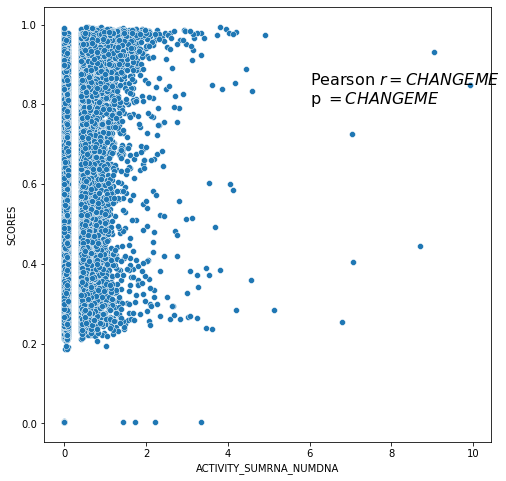

In [17]:
# Plot scatter
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#sns.regplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", x_jitter=.5, ax=ax)
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Pearson $r = CHANGE ME$' + '\n' + r'p $=CHANGE ME$', (6, 0.8), fontsize=16);

## <u> **Threshold plot** </u>

10it [00:00, 21.78it/s]


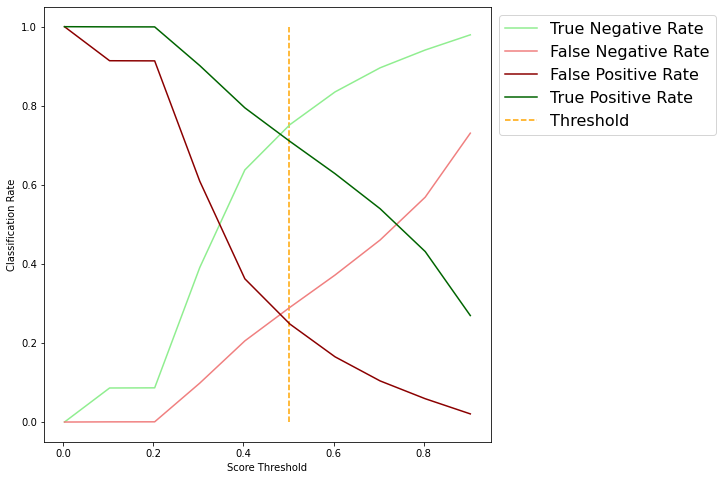

In [18]:
project_utils.threshold_plot(data, label_col="MPRA_FXN")

## <u> **Score distribution plot** </u>

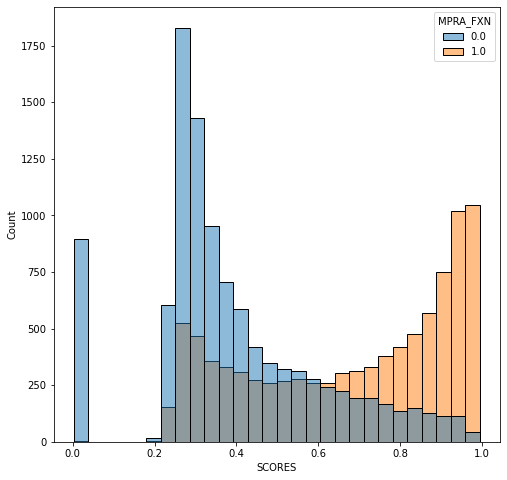

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.histplot(data=data, x="SCORES", hue="MPRA_FXN", ax=ax);
ax.vlines(0.5, 0, 1, color="red", linestyle="dashed", label="Threshold");

# Evaluate on holdout sequences

## Microscope sequences

In [20]:
microscope_mask = (~holdout_df["MICROSCOPE_FXN"].isna())
microscope_df = holdout_df[microscope_mask]
microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)
data = microscope_df
microscope_colors = dict(zip(data["MICROSCOPE_FXN"].unique(), ["darkgreen", "lightgreen", "gold", "red"]))
data["microscope_label"].value_counts()

<ipython-input-20-764356113563>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)


1    52
0    26
Name: microscope_label, dtype: int64

### <u> **Confusion matrix** </u>

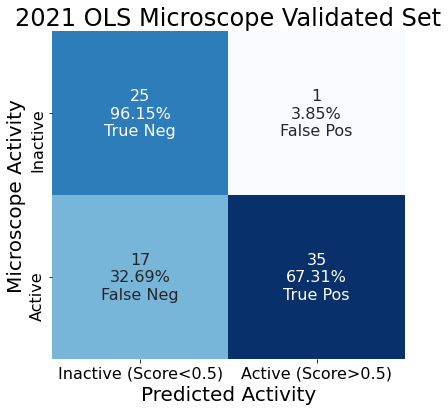

In [21]:
project_utils.cf_plot_from_df(data, label_col="microscope_label", title="2021 OLS Microscope Validated Set", ylab="Microscope Activity")

### <u> **Activity boxplot grouped by function** </u>

In [22]:
import matplotlib as mpl
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


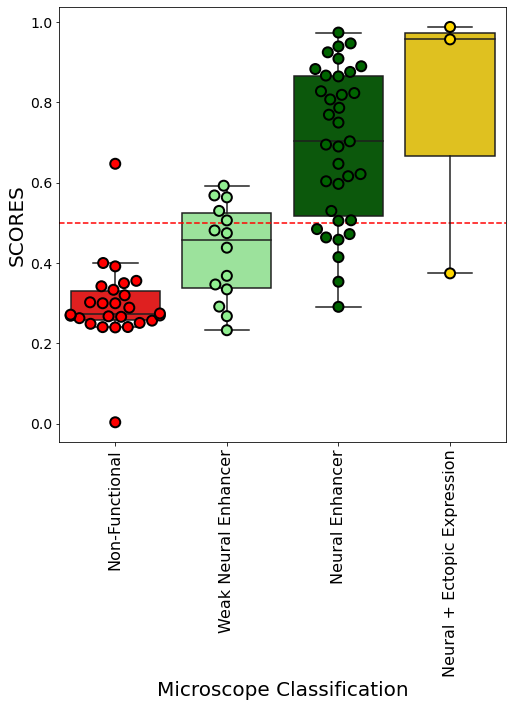

In [23]:
microscope_order = ['Non-Functional', 'Weak Neural Enhancer', 'Neural Enhancer', 'Neural + Ectopic Expression']
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.boxplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, ax=ax)
sns.swarmplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Microscope Classification", fontsize=20)
ax.set_ylabel("SCORES", fontsize=20);
plt.savefig("{}/activity_boxplot.pdf".format(OUTDIR), dpi=300)

### <u> **Swarmplot of scores** </u>

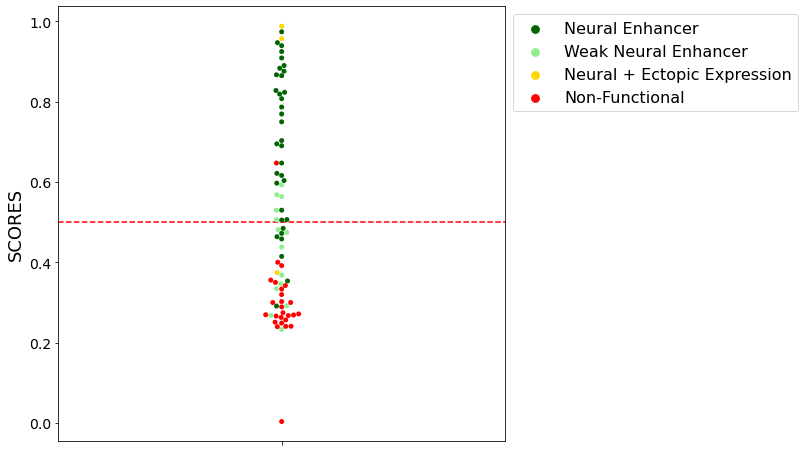

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.swarmplot(y=data["SCORES"], hue=data["MICROSCOPE_FXN"], x=[""]*len(data), palette=microscope_colors, ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");

### <u> **Scatterplot with activity** </u>

0.5515340072234409 1.6643647272173956e-07


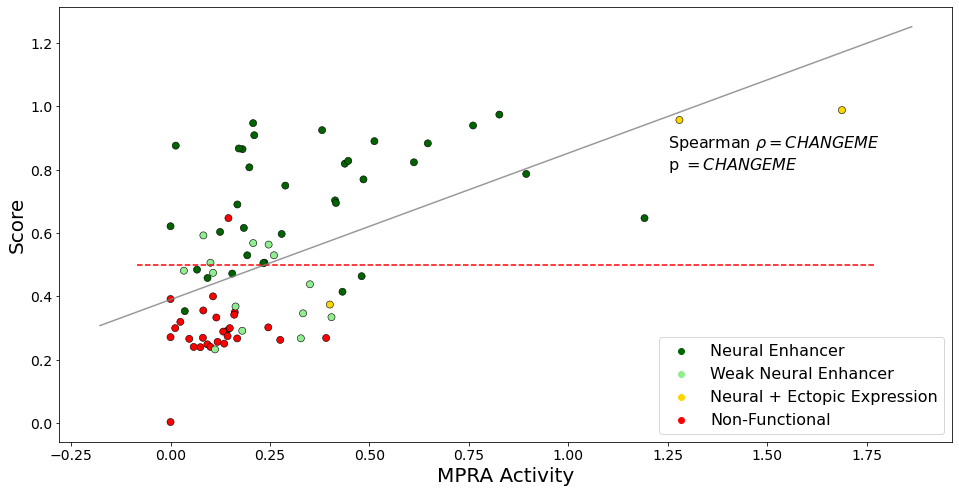

In [25]:
m, b = np.polyfit(data["ACTIVITY_SUMRNA_NUMDNA"], data["SCORES"], 1)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", hue="MICROSCOPE_FXN", palette=microscope_colors, s=50, edgecolor="black", ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");
ax.set_xlabel("MPRA Activity", fontsize=20)
ax.set_ylabel("Score", fontsize=20);
ax.legend(title='Microscope Classification', fontsize=16)

# Add trendline
x=np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 0.01)
ax.plot(x, m*x + b, '-', color = "grey", alpha=0.8)
ax.legend(loc="lower right", fontsize=16)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Spearman $\rho = CHANGE ME$' + '\n' + r'p $=CHANGEME$', (1.25, 0.8), fontsize=16);
plt.savefig("{}/activity_scatterplot.pdf".format(OUTDIR), dpi=300)

### Explanations

In [127]:
from nn_explain import deeplift_explain
import otx_enhancer_utils

In [264]:
data = OLS_dataset

In [266]:
seqs = data["SEQ"].values
#scores = data["SCORES"]
onehot_data = np.array([project_utils.one_hot_encode_along_channel_axis(x) for x in seqs])
fasta_file = "../data/2021_OLS_Library/fasta/0.09-0.4_X-all_fasta.fa"
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file)) if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file)) if i%2==0]

In [267]:
inp = torch.tensor(onehot_data).float()
num_batches = int(len(inp)/BATCH_SIZE)
imp_scores = np.empty(inp.size())
for i in range(int(len(inp)/BATCH_SIZE)):
    if i % 100 == 0 and i != 0 :
        print("{} Batches complete".format(i))
    curr_inp = inp[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
    curr_imp_scores = nn_explain(model=eugene, inputs=curr_inp, device=device, saliency_type="DeepLift", ref_type="zero", abs_value=True)
    imp_scores[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :, :] = curr_imp_scores

curr_inp = inp[i*BATCH_SIZE:]
curr_imp_scores = nn_explain(model=eugene, inputs=curr_inp, device=device, saliency_type="DeepLift", ref_type="zero", abs_value=True)
imp_scores[i*BATCH_SIZE:, :, :] = curr_imp_scores

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


100 Batches complete
200 Batches complete
300 Batches complete
400 Batches complete
500 Batches complete
600 Batches complete
700 Batches complete
800 Batches complete
900 Batches complete
1000 Batches complete
1100 Batches complete
1200 Batches complete
1300 Batches complete
1400 Batches complete
1500 Batches complete
1600 Batches complete
1700 Batches complete


In [271]:
score_df = pd.DataFrame(columns=["POS_{}".format(i+1) for i in range(66)], data=imp_scores.sum(axis=2))
cut_offs = score_df.mean(axis=1) + score_df.std(axis=1)*1

In [274]:
score_data = pd.concat([data, score_df], axis=1)
score_data.to_csv("{}/preliminary_importance_scores.tsv".format(OUTDIR), sep="\t", index=False)

{'red': [(57, 66)]}
{'red': [(14, 17), (24, 26), (56, 58), (61, 63)]}
{'red': [(27, 30), (30, 33), (35, 37), (46, 49), (52, 54)]}
{'red': [(1, 3), (39, 41), (46, 48), (50, 52), (54, 56), (57, 59), (64, 66)]}
{'red': [(45, 48), (51, 53), (56, 58), (58, 62), (63, 65)]}
{'red': [(47, 50), (54, 57), (59, 61), (61, 64), (64, 66)]}
{'red': [(43, 46), (47, 49), (50, 55), (55, 59), (59, 61), (63, 66)]}
{'red': [(0, 3), (6, 9), (10, 12), (15, 17), (17, 19), (19, 22), (23, 25)]}
{'red': [(22, 24), (46, 48), (52, 54), (55, 57), (62, 66)]}
{'red': [(23, 25), (26, 29), (35, 37), (46, 49), (56, 58), (64, 66)]}


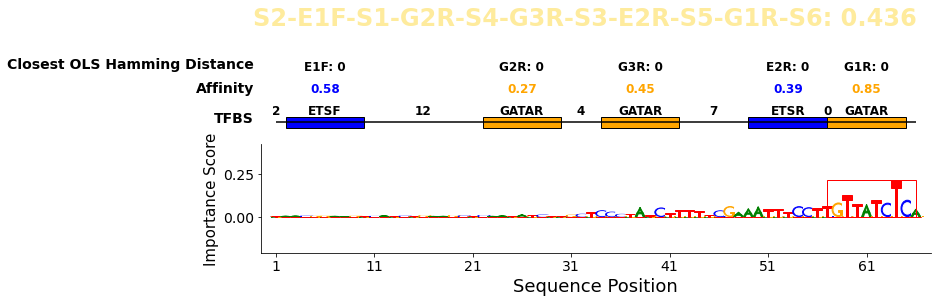

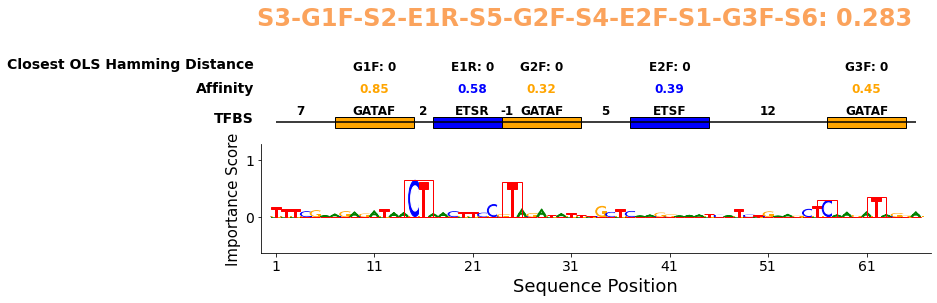

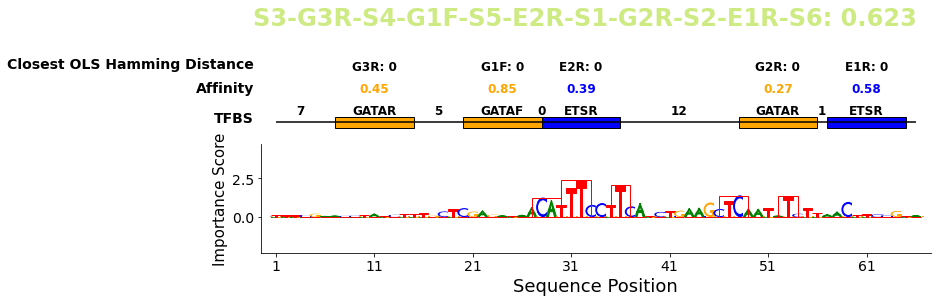

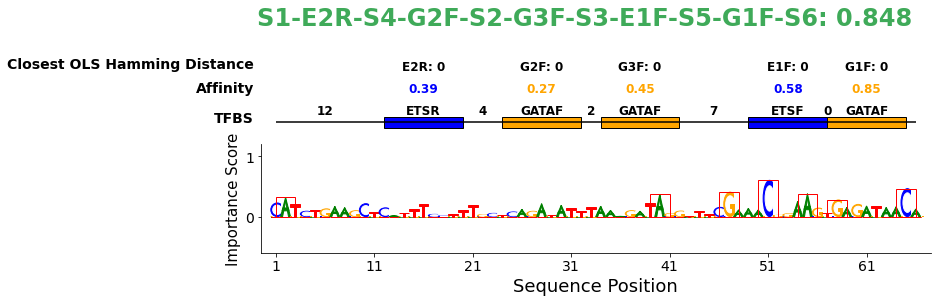

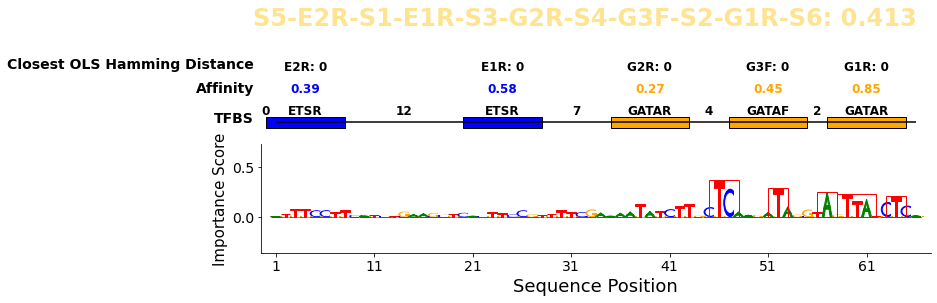

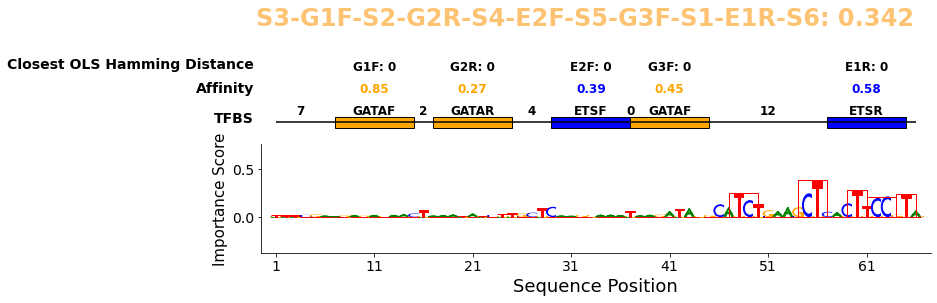

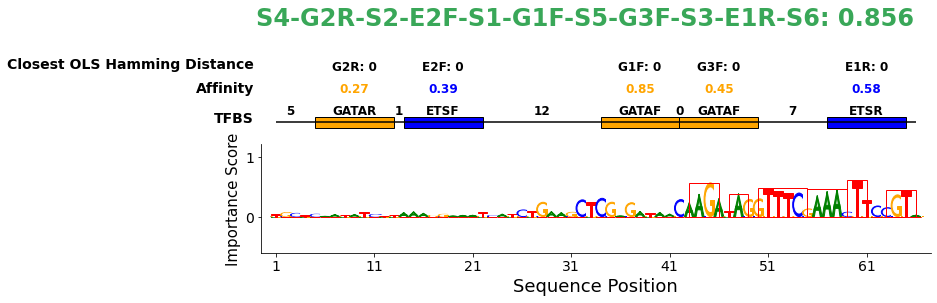

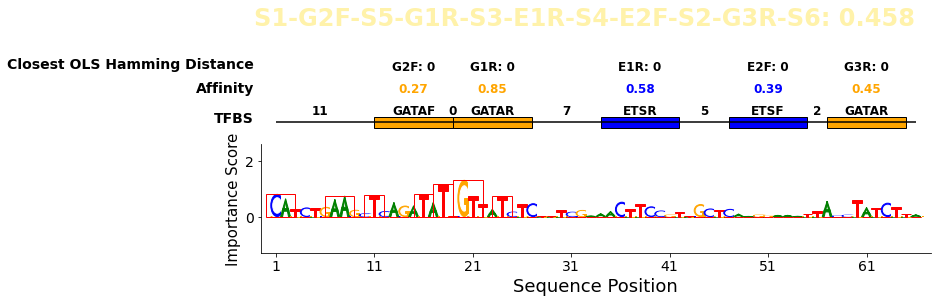

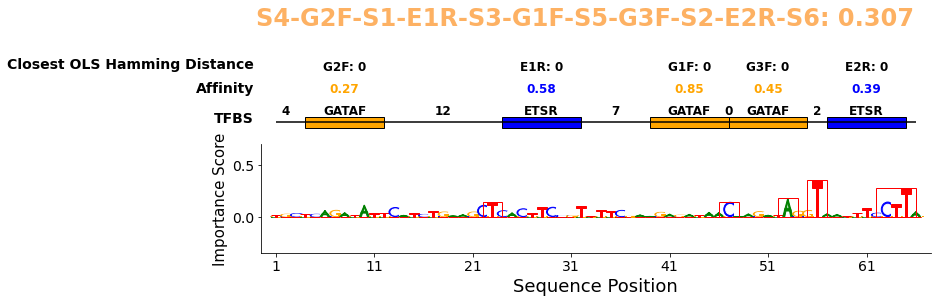

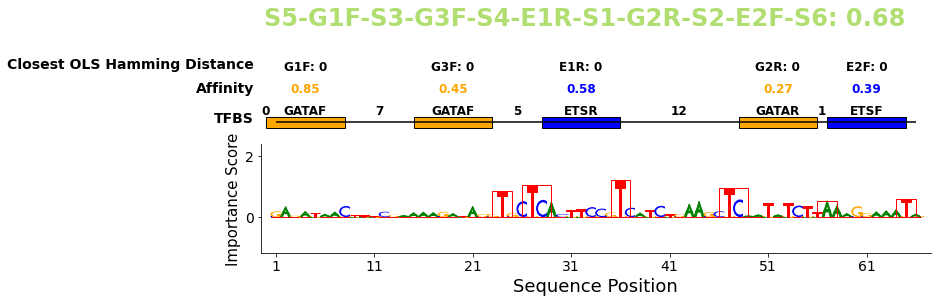

In [240]:
for i in np.random.choice(range(len(imp_scores)), size=10):
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cut_off = imp_scores[i].max(axis=1).mean() + imp_scores[i].max(axis=1).std()
    imp_pos = np.where((imp_scores[i].max(axis=1) > cut_off))[0]
    if len(imp_pos) == 0:
        continue
    otx_enhancer_utils.otxGenomeTracks(fasta_seqs[i], 
                                       importance_scores=imp_scores[i], 
                                       seq_name=fasta_ids[i], 
                                       model_pred=scores[i], 
                                       cmap=cmap, 
                                       norm=norm, 
                                       highlight = imp_pos,
                                       threshold=cut_off)

In [255]:
fasta_seqs[-1]

'CCTATCTTTGCTCAGATATTTTTCGAAATTTCCTTTAACTTCCGTCATCTGAAGCTCGAGATAACA'

In [256]:
onehot_data[-1]

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0,

In [258]:
imp_scores.sum(axis=2).sum(axis=1)

array([29.8081078 , 12.01823423,  8.58168869, ...,  4.8067425 ,
        8.37902969,  7.76097387])

In [261]:
from scipy.stats import spearmanr

In [263]:
spearmanr(imp_scores.sum(axis=2).sum(axis=1), holdout_df["SCORES"].values)

SpearmanrResult(correlation=0.6994328680588011, pvalue=0.0)

# Scratch

In [55]:
for i in range(len(flattened_genomic)):
    inp = torch.unsqueeze(torch.tensor(flattened_genomic[i]), dim=0).float()
    imp_scores = nn_explain(model=eugene, inputs=inp, device=device, saliency_type="Saliency")
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    otx_enhancer_utils.otxGenomeTracks(fasta_seqs[i], importance_scores=imp_scores, seq_name=fasta_ids[i], model_pred=genomic_dataset["SCORES"][i], cmap=cmap, norm=norm)
    if i == 5:
        break

NameError: name 'flattened_genomic' is not defined

In [15]:
onehot_data.shape

(460800, 66, 4)

In [16]:
if not RECURRENT:
    inp = np.transpose(onehot_data[7], axes=(1, 0))
inp = torch.unsqueeze(torch.tensor(inp), dim=0).float()
imp_scores = nn_explain(model=eugene, inputs=inp, device=device, saliency_type="DeepLift", ref_type="shuffle", abs_value=True)

NameError: name 'inp' is not defined

In [26]:
np.empty(inp.size()).shape

(460800, 66, 4)

In [31]:
np.save(os.path.join(OUTDIR, "seq"), inp.numpy())

In [35]:
np.save(os.path.join(OUTDIR, "seq_scores"), imp_scores)

In [87]:
data = data[["NAME", "SEQ"]]

In [92]:
len(data), len(imp_scores)

(460800, 460800)

In [103]:
score_df = pd.DataFrame(columns=["POS_{}".format(i+1) for i in range(66)], data=imp_scores.sum(axis=2))

In [106]:
score_data = pd.concat([data, score_df], axis=1)

In [108]:
score_data.to_csv("{}/preliminary_importance_scores.tsv".format(OUTDIR), sep="\t", index=False)

In [23]:
from models import dsLSTM

In [109]:
score_data.head()

,NAME,SEQ,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,...,POS_57,POS_58,POS_59,POS_60,POS_61,POS_62,POS_63,POS_64,POS_65,POS_66
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,0.557959,0.411266,0.033400,0.595404,0.084576,0.118495,0.092275,0.113906,...,1.086083,0.153482,0.081431,0.174682,0.093563,0.760579,0.116722,0.067223,0.066292,0.050202
1,S1-G1F-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGAGATAACTAACGGAAGTTTTCGAAAAGGAAATT...,0.081378,0.078486,0.018522,0.017722,0.021830,0.027755,0.091232,0.042795,...,0.456326,0.168284,0.181046,0.087261,0.201306,0.451248,0.180698,0.077597,0.068129,0.040834
2,S1-G1R-S2-E1F-S3-E2F-S4-G2F-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,0.014425,0.081673,0.053967,0.014532,0.078535,0.046951,0.102979,0.073298,...,0.024570,0.064254,0.100270,0.082408,0.134111,0.235186,0.151196,0.057099,0.035030,0.041588
3,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3R-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,0.370696,0.348600,0.040299,0.414111,0.017496,0.166326,0.246693,0.218284,...,0.441370,0.367000,0.352372,0.188324,0.079791,0.922813,0.541545,0.606914,0.202111,0.115112
4,S1-G1R-S2-E1R-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACTTCCGTTTTCGAAAAGGAAATT...,0.207595,0.451407,0.228826,0.171741,0.257553,0.070375,0.138604,0.093616,...,0.196338,0.177301,0.180537,0.440060,0.095117,0.281968,0.131094,0.028614,0.110687,0.132627


In [52]:
imp_scores = nn_explain(model=eugene, inputs=inp, device=device, saliency_type="DeepLift", ref_type="zero", abs_value=True)

torch.Size([460800, 66, 4])


ValueError: Expected string or one-hot encoded array

In [35]:
otx_enhancer_utils.otxGenomeTracks(seqs[7], importance_scores=imp_scores, seq_name=ids[7], model_pred=scores[7], cmap=cmap, norm=norm)
#plt.savefig("{}/example_explain.pdf".format(OUTDIR), dpi=300)

NameError: name 'seqs' is not defined

In [499]:
data.iloc[7]

NAME                                  S5-G2F-S4-G1F-S1-E1R-S2-E2R-S3-G3F-S6
SEQ                       AGATATTTGCTCGAGATAACCATCTGAAGCTCACTTCCGTTAATTT...
MPRA_FXN                                                                1.0
MICROSCOPE_FXN                                              Neural Enhancer
ACTIVITY_SUMRNA_NUMDNA                                             0.446655
SEQ_LEN                                                                  66
linker_1                                                                 S5
TFBS_1                                                                  G2F
linker_2                                                                 S4
TFBS_2                                                                  G1F
linker_3                                                                 S1
TFBS_3                                                                  E1R
linker_4                                                                 S2
TFBS_4      

In [40]:
for i in range(len(flattened_genomic)):
    if not RECURRENT:
        inp = np.transpose(onehot_data[i], axes=(1, 0))
    inp = torch.unsqueeze(torch.tensor(inp), dim=0).float()
    imp_scores = nn_explain(model=eugene, inputs=inp, device=device, saliency_type="DeepLift", ref_type="shuffle", abs_value=True)
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    otx_enhancer_utils.otxGenomeTracks(seqs[i], importance_scores=imp_scores, seq_name=ids[i], model_pred=scores[i], cmap=cmap, norm=norm)
    if i==19:
        break

NameError: name 'flattened_genomic' is not defined

## No label sequences

In [258]:
ambiguous_df = holdout_df[~microscope_mask]
data = ambiguous_df

0.22563681672684735 0.0


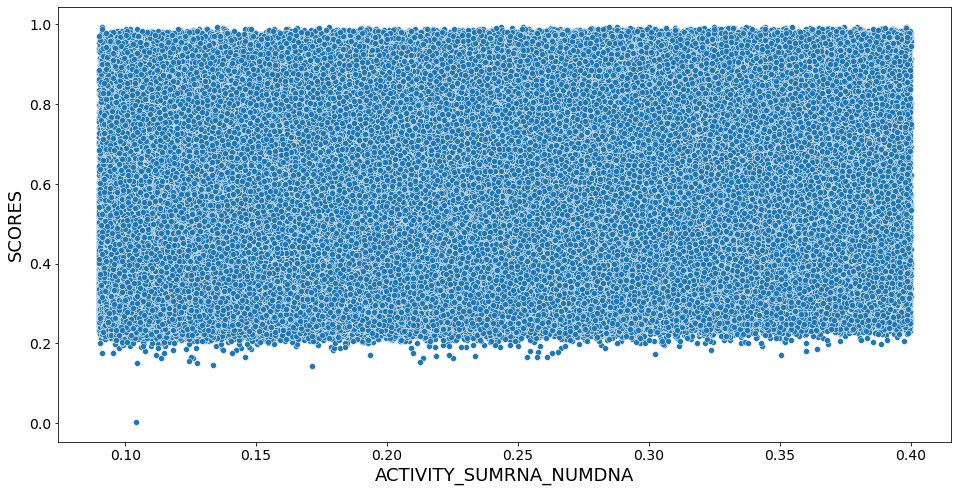

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=ambiguous_df, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)
no_na = (~ambiguous_df["ACTIVITY_SUMRNA_NUMDNA"].isna())
p, r = stats.pearsonr(ambiguous_df[no_na]["ACTIVITY_SUMRNA_NUMDNA"], ambiguous_df[no_na]["SCORES"])
print(p, r)

# Evaluate on genomic sequences

## Full sequences

In [26]:
# Set data variable
data = genomic_dataset

### <u> **Confusion matrix** </u>

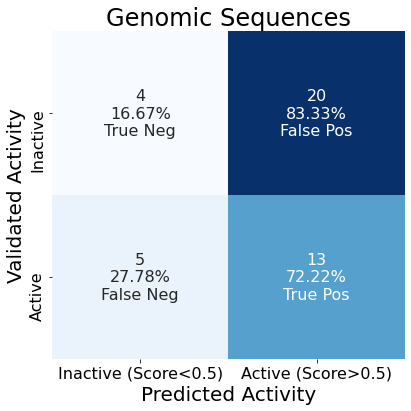

In [27]:
project_utils.cf_plot_from_df(data, title="Genomic Sequences", ylab="Validated Activity")

### <u> **Feature importances** </u>
This will probably vary significantly between model types. Below is a simple example case for linear regression

In [57]:
from captum.attr import Saliency, DeepLift, GuidedGradCam
def nn_explain(model, 
               inputs, 
               saliency_type, 
               target=None, 
               ref_type=None,
               device="cpu",
               abs_value=False):
    if saliency_type == "DeepLift":
        attrs = deeplift_explain(model=model, inputs=inputs, ref_type=ref_type, device=device, target=target)
    elif saliency_type == "Saliency":
        attrs = vanilla_explain(model=model, inputs=inputs, ref_type=ref_type, device=device, target=target)
    elif saliency_type == "GuidedGradCam":
        attrs = gradcam_explain(model=model, inputs=inputs, ref_type=ref_type, device=device, target=target)
    if abs_value:
        attrs = np.abs(attrs)
    return attrs

def gradcam_explain(model, inputs, ref_type=None, target=None, device="cpu"):
    from captum.attr import GuidedGradCam
    model.train()
    model.to(device)
    vanilla = Saliency(model)
    inputs.requires_grad_()
    inputs = inputs.to(device)
    #if isinstance(model, dsLSTM):
    #    pass
    else:
        attrs = vanilla.attribute(inputs=inputs)
    return attrs.to("cpu").detach().numpy()

def vanilla_explain(model, inputs, ref_type=None, target=None, device="cpu"):
    from captum.attr import Saliency
    model.train()
    model.to(device)
    vanilla = Saliency(model)
    inputs.requires_grad_()
    inputs = inputs.to(device)
    #if isinstance(model, dsLSTM):
    #    pass
    #else:
    attrs = vanilla.attribute(inputs=inputs)
    return attrs.to("cpu").detach().numpy()

def deeplift_explain(model, inputs, ref_type="zero", target=None, device="cpu"):
    import dinuc_shuffle
    from captum.attr import DeepLift
    model.train()
    model.to(device)
    deep_lift = DeepLift(model)
    inputs.requires_grad_()
    inputs = inputs.to(device)
    if ref_type == "zero":
        ref = torch.zeros(inputs.size()).to(device)
    elif ref_type == "shuffle":
        print(inputs.size())
        to_shuf = inputs.detach().to("cpu").squeeze(dim=0).numpy()
        ref = torch.tensor(dinuc_shuffle.dinuc_shuffle(to_shuf)).unsqueeze(dim=0).to(device)
    elif ref_type == "gc":
        ref = torch.tensor([0.3, 0.2, 0.2, 0.3]).expand(inp.size()[1], 4).unsqueeze(dim=0).to(device)
    ref.requires_grad_()
    #if isinstance(model, dsLSTM):
    #    pass
    else:
        attrs = deep_lift.attribute(inputs=inputs, baselines=ref)
    return attrs.to("cpu").detach().numpy()

In [25]:
flattened_genomic = np.concatenate(X_genomic)
fasta_file = "../data/All_Genomic_Sequences/fasta/X_fasta.fa"
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file)) if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file)) if i%2==0]
onehot_data = np.array([project_utils.one_hot_encode_along_channel_axis(x) for x in fasta_seqs])

NameError: name 'X_genomic' is not defined

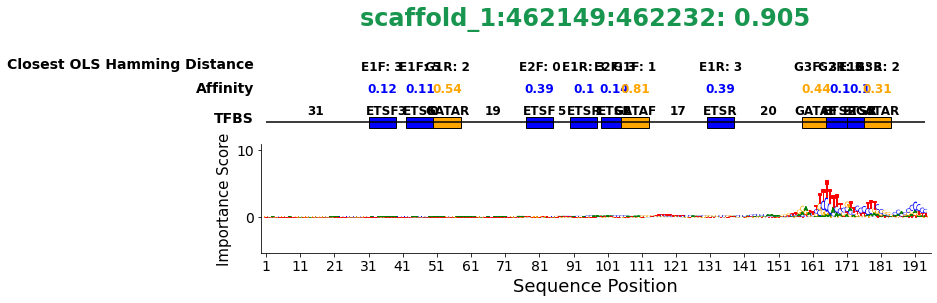

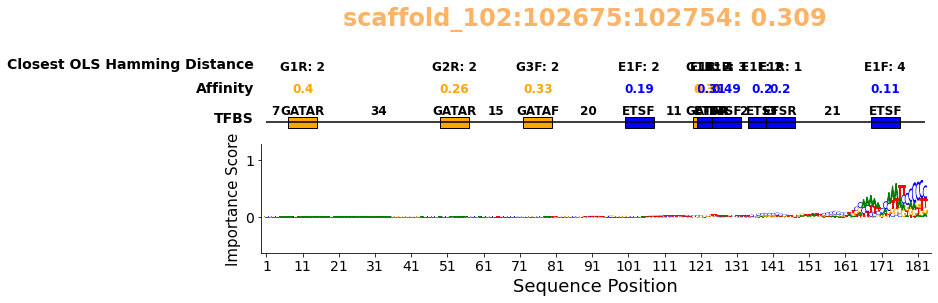

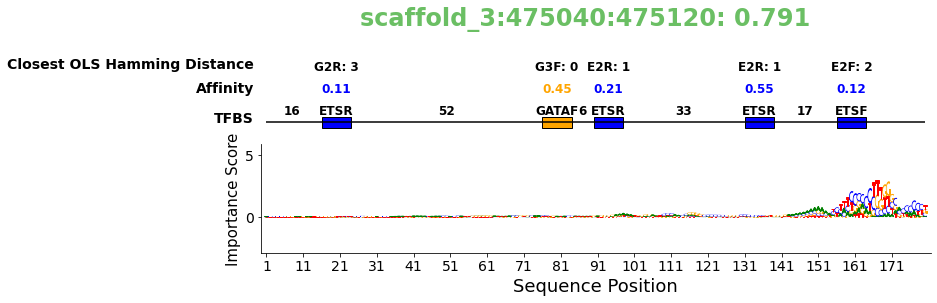

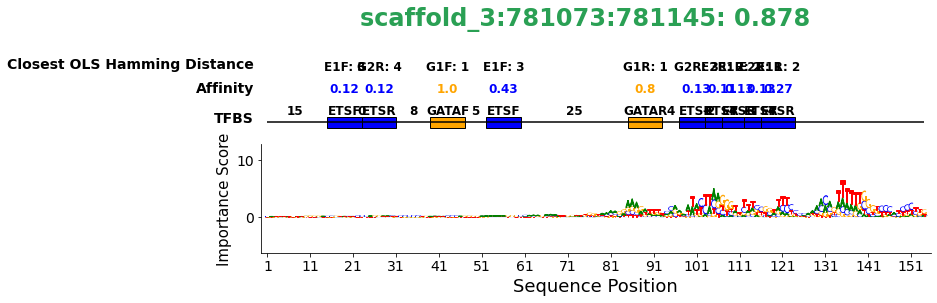

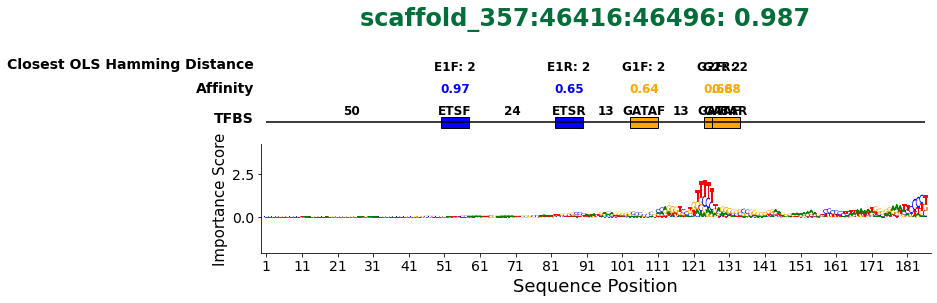

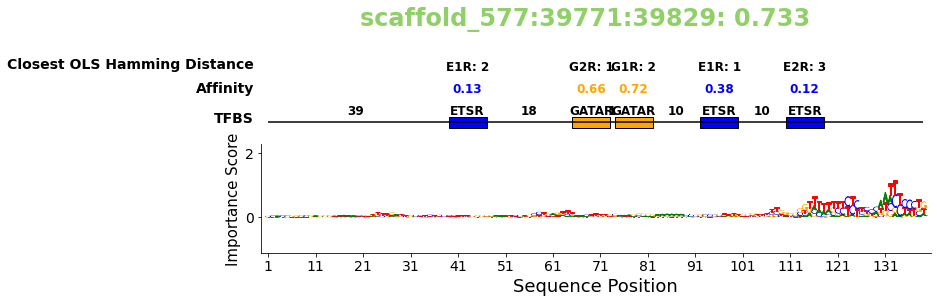

In [387]:
for i in range(len(flattened_genomic)):
    inp = torch.unsqueeze(torch.tensor(flattened_genomic[i]), dim=0).float()
    imp_scores = nn_explain(model=eugene, inputs=inp, device=device, saliency_type="Saliency")
    cmap = mpl.cm.RdYlGn
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    otx_enhancer_utils.otxGenomeTracks(fasta_seqs[i], importance_scores=imp_scores, seq_name=fasta_ids[i], model_pred=genomic_dataset["SCORES"][i], cmap=cmap, norm=norm)
    if i == 5:
        break

# Scratch

In [ ]:
from captum.attr import Saliency, DeepLift
def nn_explain(model, inputs, target=None, saliency_type="Saliency", ref_type=None):
    model.train()
    if saliency_type == "DeepLift":
        explainer = DeepLift(model)
    elif saliency_type == "Saliency":
        explainer = Saliency(model)
    if isinstance(model, dsLSTM):
        forward_input = inputs[0]
        reverse_input = inputs[1]
        
        


In [196]:
eugene.train()

deep_lift = DeepLift(eugene)

inp = torch.unsqueeze(torch.tensor(X_genomic[2][0]), dim=0).float().to(device)
inp.requires_grad_
if "ds" in ARCHITECTURE:
    rev_inp = torch.unsqueeze(torch.tensor(X_genomic_rev[2][0]), dim=0).float().to(device)
    rev_inp.requires_grad_

In [198]:
ref_0 = torch.zeros(inp.size()).to(device)

In [200]:
test = inp.detach().to("cpu").squeeze(dim=0).numpy()

In [201]:
ref_shuf = dinuc_shuffle.dinuc_shuffle(test)

In [202]:
ref_shuf = torch.tensor(ref_shuf).unsqueeze(dim=0).to(device)

In [227]:
ref_gc = torch.tensor([0.3, 0.2, 0.2, 0.3]).expand(inp.size()[1], 4).unsqueeze(dim=0).to(device)

In [228]:
inp.size(), rev_inp.size(), ref_0.size(), ref_shuf.size(), ref_gc.size()

(torch.Size([1, 53, 4]),
 torch.Size([1, 53, 4]),
 torch.Size([1, 53, 4]),
 torch.Size([1, 53, 4]),
 torch.Size([1, 53, 4]))

In [229]:
forward_exp, reverse_exp = deep_lift.attribute(inputs=(inp, rev_inp), baselines=(ref_gc, ref_gc))

In [230]:
forward_exp = forward_exp.detach().cpu().numpy()

In [231]:
reverse_exp = reverse_exp.detach().cpu().numpy()

# References

 1. Ref 1
 2. Ref 2